### Семинар 7: Семантическая Сегментация
[Используем предобученные модели из PyTorch для решения задачи](https://docs.pytorch.org/vision/main/models.html#semantic-segmentation)


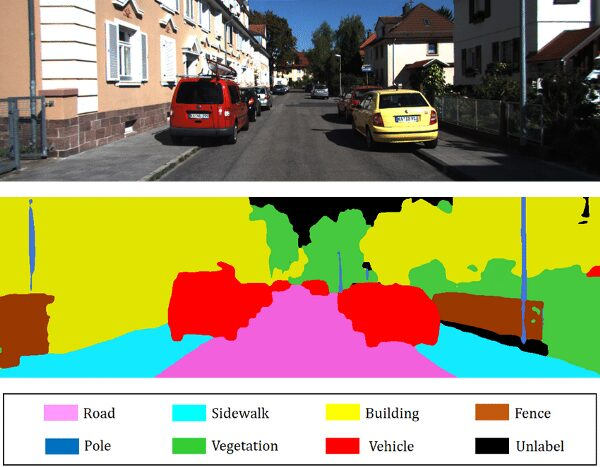

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests
import numpy as np

from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

### FCN ResNet50

In [6]:
# Загрузка изображения
url = 'https://raw.githubusercontent.com/lysukhin/ai-masters-ml3-seminars/main/06_mask_r_cnn/1.jpg'
r = requests.get(url)
img = Image.open(BytesIO(r.content)).convert("RGB")
img_np = np.array(img)
H, W = img_np.shape[:2]

# Инициализация модели
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval()

# Предобработка
preprocess = weights.transforms()
batch = preprocess(img).unsqueeze(0)

# Предсказание
with torch.no_grad():
    prediction = model(batch)["out"]  # [1, num_classes, H_out, W_out]

# Интерполируем маску до размера исходного изображения
upsampled_masks = F.interpolate(
    prediction,
    size=(H, W),
    mode="bilinear",
    align_corners=False
)
normalized_masks = upsampled_masks.softmax(dim=1)  # [1, num_classes, H, W]

# Категории
categories = weights.meta["categories"]

# Находим наиболее уверенный класс (игнорируя background)
class_scores = normalized_masks[0].amax(dim=(1, 2))  # [num_classes]
top_classes = torch.topk(class_scores[1:], k=3).indices + 1
best_class_idx = top_classes[0].item()
best_class_name = categories[best_class_idx]
best_mask = normalized_masks[0, best_class_idx].cpu()  # [H, W]

In [3]:
preprocess

SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [4]:
categories

['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

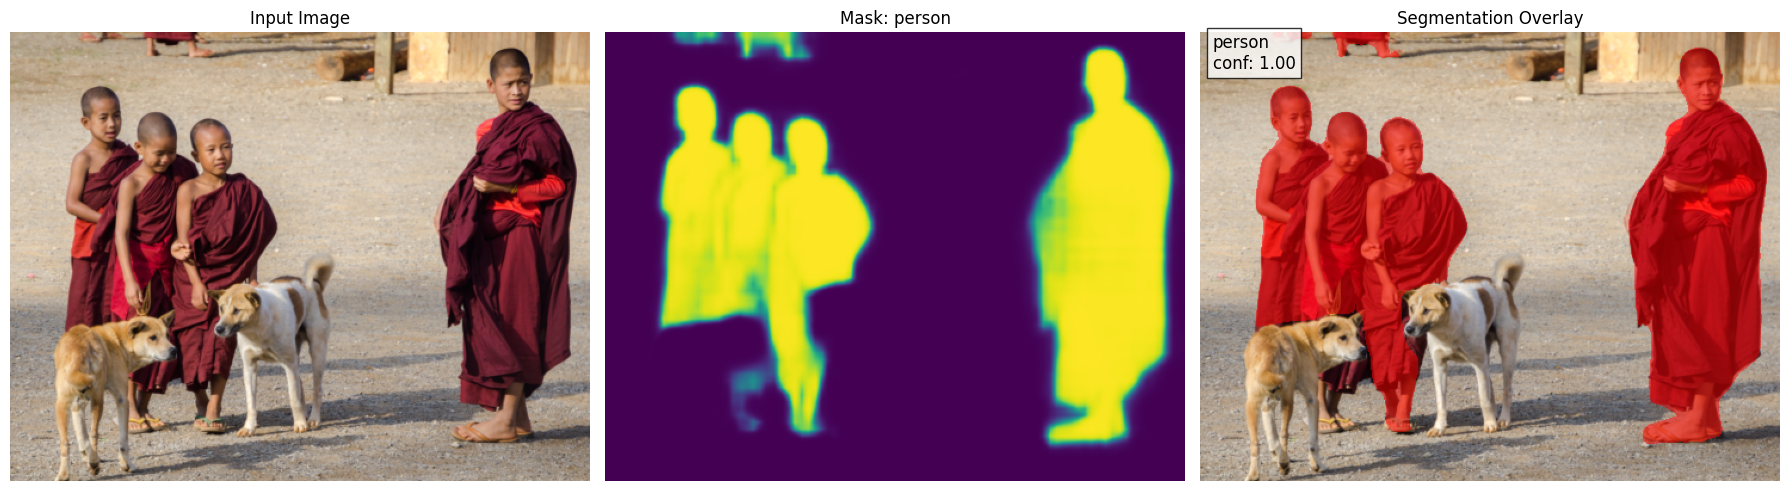

In [7]:
# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Исходное изображение
axes[0].imshow(img)
axes[0].set_title("Input Image")
axes[0].axis("off")

# 2. Маска
axes[1].imshow(best_mask, cmap="viridis")
axes[1].set_title(f"Mask: {best_class_name}")
axes[1].axis("off")

# 3. Наложение маски
overlay = img_np.copy()
mask_binary = (best_mask > 0.5).numpy()
# Наложение только на те пиксели, где маска активна
overlay[mask_binary] = (
    overlay[mask_binary] * 0.5 + np.array([255, 0, 0]) * 0.5
).astype(np.uint8)

axes[2].imshow(overlay)
max_score = best_mask.max().item()
axes[2].text(10, 30, f"{best_class_name}\nconf: {max_score:.2f}",
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=12, color='black')
axes[2].set_title("Segmentation Overlay")
axes[2].axis("off")

plt.tight_layout()
plt.show()

### DeepLabV3 ResNet50

In [8]:
# Загрузка изображения
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url = 'http://images.cocodataset.org/val2017/000000000872.jpg'
r = requests.get(url)
img = Image.open(BytesIO(r.content)).convert("RGB")
img_np = np.array(img)
H, W = img_np.shape[:2]

# Инициализация модели DeepLabV3
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)
model.eval()

# Предобработка (включает resize до 520x520 и нормализацию)
preprocess = weights.transforms()
batch = preprocess(img).unsqueeze(0)

# Предсказание
with torch.no_grad():
    prediction = model(batch)["out"]  # [1, num_classes, H_out, W_out]

# Интерполяция маски до оригинального размера изображения
upsampled_masks = F.interpolate(
    prediction,
    size=(H, W),
    mode="bilinear",
    align_corners=False
)
normalized_masks = upsampled_masks.softmax(dim=1)  # [1, num_classes, H, W]

# Категории (COCO-stuff или Pascal VOC, в зависимости от весов)
categories = weights.meta["categories"]

# Выбор наиболее уверенного класса (игнорируем background = индекс 0)
class_scores = normalized_masks[0].amax(dim=(1, 2))  # [num_classes]
top_classes = torch.topk(class_scores[1:], k=3).indices + 1
best_class_idx = top_classes[0].item()
best_class_name = categories[best_class_idx]
best_mask = normalized_masks[0, best_class_idx].cpu()  # [H, W]

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:01<00:00, 139MB/s]


In [10]:
categories

['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

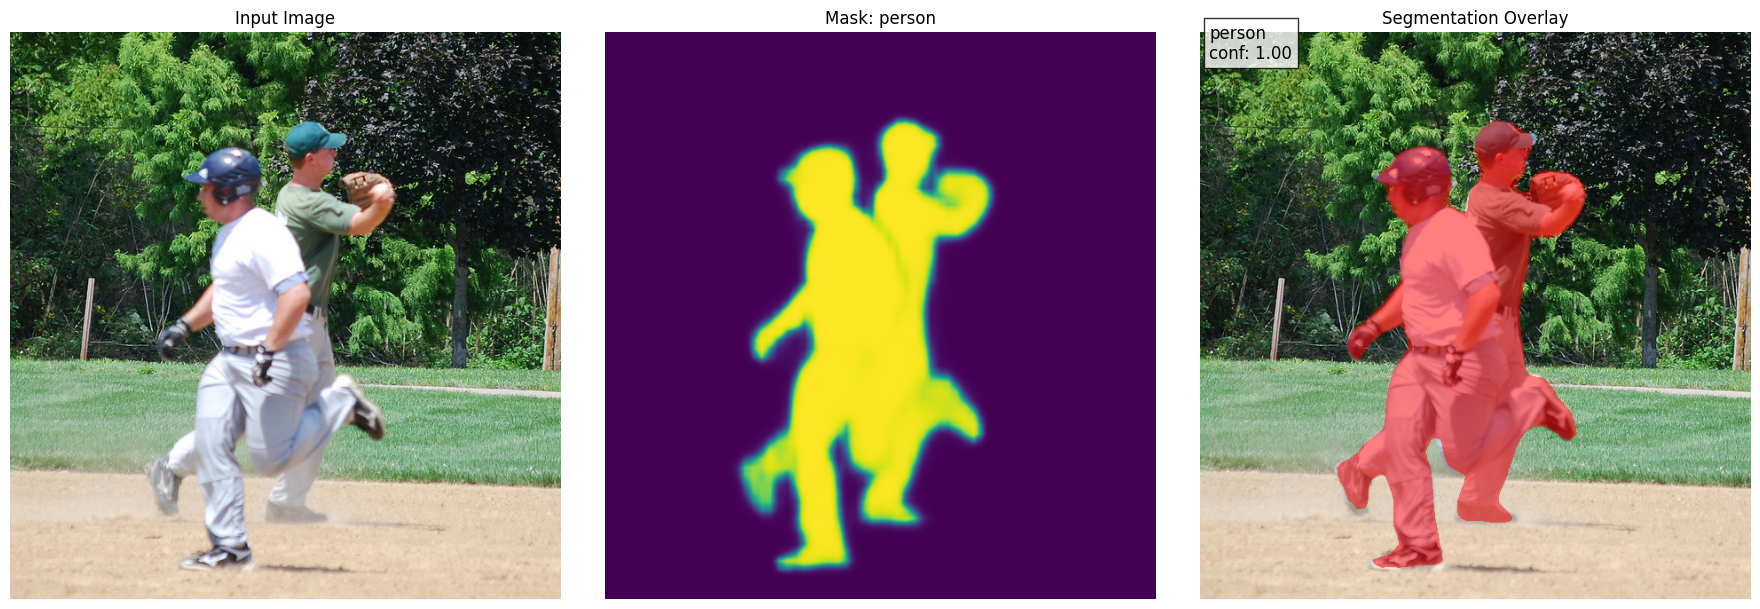

In [9]:
# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Исходное изображение
axes[0].imshow(img)
axes[0].set_title("Input Image")
axes[0].axis("off")

# 2. Маска сегментации
axes[1].imshow(best_mask, cmap="viridis")
axes[1].set_title(f"Mask: {best_class_name}")
axes[1].axis("off")

# 3. Наложение маски на изображение
overlay = img_np.copy()
mask_binary = (best_mask > 0.5).numpy()
overlay[mask_binary] = (
    overlay[mask_binary] * 0.5 + np.array([255, 0, 0]) * 0.5
).astype(np.uint8)

axes[2].imshow(overlay)
max_score = best_mask.max().item()
axes[2].text(10, 30, f"{best_class_name}\nconf: {max_score:.2f}",
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=12, color='black')
axes[2].set_title("Segmentation Overlay")
axes[2].axis("off")

plt.tight_layout()
plt.show()